In [360]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [264]:
class LSE:
    def __init__(self , x , y , n , l):
        self.x = x
        self.y = y
        self.n = n
        self.Lambda = l
        self.x_table = self.createtable(x)
        self.Beta = self.__calculatebeta(x , y)
        self.error = self.__calerror(x , y)

    def createtable(self,x):
        x_table = np.zeros((len(x),self.n) , dtype = np.float32)
        for i in range(self.n):
            x_table[:,i] = x**i
        return x_table

    
    def __calculatebeta(self , x , y):
        A = np.zeros((self.n,self.n) , dtype = np.float32)
        for i in range(self.n):
            for j in range(self.n):
                times = i+j
                A[i,j] = (x**times).sum()
                if i == j:
                    A[i,j] += self.Lambda
        
        Inv = self.LUdecompose(A)
        
        return Inv@self.x_table.T@y

    def LUdecompose(self , A):
        U = A.copy()
        L = np.array([[float(i == j) for i in range(self.n)] for j in range(self.n)])

        for i in range(self.n):
            factor = U[i+1:, i] / U[i, i]
            L[i+1:, i] = factor
            U[i+1:] -= factor[:, np.newaxis] * U[i]

        inv_L , inv_U = L.copy() , U.copy()
        I_L = np.array([[float(i == j) for i in range(len(L))] for j in range(len(L))])
        I_U = np.array([[float(i == j) for i in range(len(L))] for j in range(len(L))])

        for i in range(len(inv_L)):
            factor = inv_L[i+1:, i] / inv_L[i, i]
            I_L[i+1:,:] -= factor[:, np.newaxis]*I_L[i,:]

        for i in range(len(inv_U)-1 , -1 , -1):
            factor = inv_U[0:i,i] / inv_U[i,i]
            I_U[:i,:] -= factor[: , np.newaxis]*I_U[i,:]
            if inv_U[i,i] != 1:
                I_U[i,:] /= inv_U[i,i]
        
        return I_U@I_L
                

    def __calerror(self , x , y):
        estimate = self.x_table@self.Beta.T
        error = sum((y - estimate)**2)
        return error
    

    

In [331]:
class Newton:
    def __init__(self , x , y ,n):
        self.x = x
        self.y = y
        self.n = n
        self.x_table = self.createtable(x)
        self.Beta = self.__calculatebeta()
        self.error = self.__calerror()

    def createtable(self,x):
        x_table = np.zeros((len(x),self.n) , dtype = np.float32)
        for i in range(self.n):
            x_table[:,i] = x**i
        return x_table

    def __calculatebeta(self):
        Hessian = self.x_table.T@self.x_table
        Mat = Hessian.copy()
        pviot_m = np.array([[float(i==j) for i in range(self.n)] for j in range(self.n)])

        for i in range(self.n):
            factor = Hessian[i+1:, i] / Hessian[i, i]
            pviot_m[i+1:,:] -= factor[:, np.newaxis]*pviot_m[i,:]
            Hessian[i+1:,:] -= factor[:, np.newaxis]*Hessian[i,:]

        for i in range(self.n-1 , -1 , -1):
            factor = Hessian[0:i,i] / Hessian[i,i]
            pviot_m[:i,:] -= factor[: , np.newaxis]*pviot_m[i,:]
            Hessian[:i,:] -= factor[: , np.newaxis]*Hessian[i,:]
            if Hessian[i,i] != 1:
                pviot_m[i,:] /= Hessian[i,i]
                Hessian[i,i] /= Hessian[i,i]
        
        return pviot_m@self.x_table.T@self.y

    def __calerror(self):
        estimate = self.x_table@self.Beta.T
        error = sum((y - estimate)**2)
        return error


In [377]:
def show_plot(x , y , coef1 , coef2):
    LSE = np.poly1d(coef1[::-1])
    New = np.poly1d(coef2[::-1])

    linespace = np.linspace(int(x.min()), int(x.max()), int(y.max()))
    plt.scatter(x , y)
    plt.plot(linespace, LSE(linespace))
    plt.show()

    plt.scatter(x , y)
    plt.plot(linespace, New(linespace), color = 'red')
    plt.show()


LSE: 
Fitting Line: 29.306404661816913x^0 + 4.432950302508808x^1 
Total error: 16335.12323087678
Newton Method: 
Fitting Line: 29.306404937685414x^0 + 4.432949918655585x^1 
Total error: 16335.123230876805


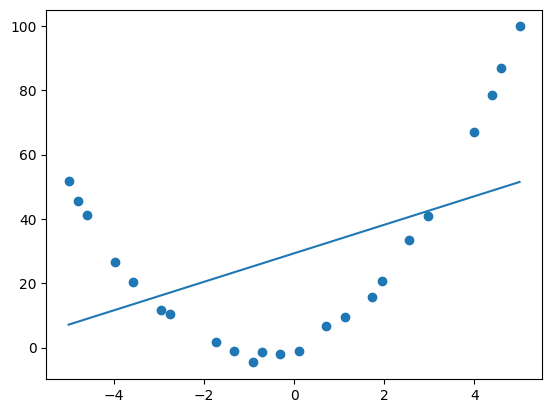

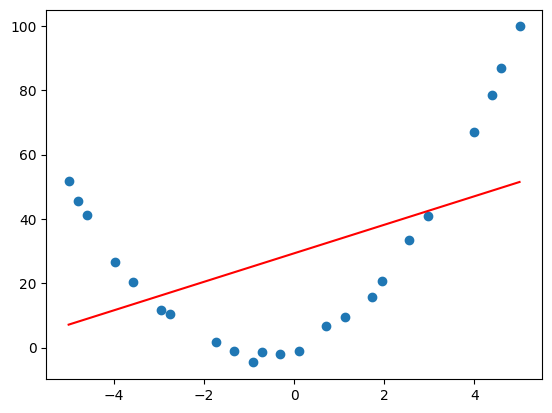

In [380]:
if __name__ == '__main__':
    colnames = ['x' , 'y']
    data = pd.read_csv('testfile.txt' , sep = ',' , header = None , names = colnames)
    x = np.array(data['x'])
    y = np.array(data['y'])
    n = 2
    l = 0

    model1 = LSE(x , y , n , l)
    model2 = Newton(x , y , n)

    fit_LSE = ' + '.join([f'{j}x^{i}' for i , j in enumerate(model1.Beta)])
    fit_New = ' + '.join([f'{j}x^{i}' for i , j in enumerate(model2.Beta)])
    print(f'LSE: \nFitting Line: {fit_LSE} \nTotal error: {model1.error}')
    print(f'Newton Method: \nFitting Line: {fit_New} \nTotal error: {model2.error}')

    show_plot(x , y , model1.Beta , model2.Beta)  